In [1]:
# 導入必要的庫
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

matplotlib.rc("font", family="Microsoft JhengHei")

# 設置字型及解決負號顯示問題
matplotlib.rcParams["axes.unicode_minus"] = False

import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(
    r"/Volumes/Debbie 1T/BDSE35-1_Final Project_2/data/實價登錄房價_237832row_cleaned.csv",
    encoding="utf-8-sig",
)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237832 entries, 0 to 237831
Data columns (total 51 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   鄉鎮市區         237832 non-null  object 
 1   土地位置建物門牌     237832 non-null  object 
 2   交易年月日        237832 non-null  object 
 3   建築完成年月       212559 non-null  float64
 4   建物移轉總面積平方公尺  237832 non-null  float64
 5   有無管理組織       237832 non-null  object 
 6   總價元          237832 non-null  int64  
 7   單價元平方公尺      237832 non-null  float64
 8   備註           65379 non-null   object 
 9   編號           237832 non-null  object 
 10  緯度           237832 non-null  float64
 11  經度           237832 non-null  float64
 12  bad_count    237832 non-null  float64
 13  good_count   237832 non-null  float64
 14  建築型態清整       237832 non-null  object 
 15  陽台有無         237832 non-null  int64  
 16  是否含額外土地      237832 non-null  int64  
 17  建築型態_住商大樓    237832 non-null  int64  
 18  建築型態_公寓      237832 non-

In [4]:
df.head()

,鄉鎮市區,土地位置建物門牌,交易年月日,建築完成年月,建物移轉總面積平方公尺,有無管理組織,總價元,單價元平方公尺,備註,編號,...,有無電梯,Region,建物移轉總面積坪,單價元每坪,房地總價元(坪),交易年份,建築完成年,交易年_民國,屋齡,屋齡區間
0,中西區,臺南市中西區金華路三段２１８號十五樓之１７,2022-09-02,840704.0,43.51,有,2170000,49874.0,NaN,RPVOMLLJRHHGFAD08DA,...,1.0,A,143.834705,164872.721090,2.371442e+07,2022,84,111,27,21年以上－未滿30年
1,北區,臺南市北區南園街１２７巷１５１弄３號,2022-08-01,640322.0,69.20,無,4500000,65029.0,NaN,RPOOMLSJQHHGFAD97DA,...,0.0,A,228.760322,214971.892765,4.917704e+07,2022,64,111,47,30年以上
2,佳里區,臺南市佳里區麻興路二段５３１號,2022-08-04,890919.0,130.97,無,8440000,64442.0,親友、員工、共有人或其他特殊關係間之交易；,RPQNMLKKQHHGFGD97DA,...,0.0,B,432.958661,213031.396970,9.223379e+07,2022,89,111,22,21年以上－未滿30年
3,新化區,臺南市新化區中正路６６２巷２２號,2022-08-01,650600.0,110.40,無,1200000,10870.0,親友、員工、共有人或其他特殊關係間之交易；,RPSOMLPJQHHGFHD78DA,...,0.0,A,364.958664,35933.882950,1.311438e+07,2022,65,111,46,30年以上
4,中西區,臺南市中西區南寧街１３６巷９號,2022-08-01,510000.0,81.05,無,10600000,130783.0,NaN,RPPNMLKKQHHGFAD37EA,...,0.0,A,267.933874,432340.479655,1.158387e+08,2022,51,111,60,30年以上


### 在應用 Isolation Forest 進行異常值檢測和 PCA 進行降維與視覺化時，是否應該將不同類別的特徵（如位置相關特徵、房屋物理特徵等）一起處理，還是分開處理，取決於您的分析目標和數據特性
* 分開處理的優勢：有助於深入理解各特徵類別的數據特性，便於針對性地清洗和預處理。
* 一起處理的優勢：能夠捕捉跨特徵類別的異常，提供全局性的數據視圖，有助於構建更精確的預測模型。
* 綜合考量：建議先分開處理，再一起處理，結合兩種方法的優點，全面提升數據質量和模型性能。


In [5]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

## 房屋物理特徵
- 建物移轉總面積坪（建物移轉總面積坪）：房屋的總面積，直接影響房價。
- 格局比例_房、格局比例_廳、格局比例_衛（格局比例_房、格局比例_廳、格局比例_衛）：反映房屋的內部布局，房、廳、衛的數量。
- 建築型態清整（建築型態清整）：如公寓、大樓、透天厝等，不同的建築型態價格差異較大。
- 屋齡（屋齡）：房屋的年齡，通常新房價格較高。
- 有無電梯（有無電梯）：對於高樓層建築，有無電梯影響便利性和價格。
- 是否包含車位（是否包含車位）：車位是重要的附加價值。
- 陽台有無（陽台有無）：陽台增加房屋的使用價值和舒適度。
- 有無管理組織（有無管理組織）：有管理的社區通常安全性和服務品質較高。
## 位置相關特徵
- 鄉鎮市區（鄉鎮市區）：反映房產的大致位置，對房價有顯著影響。
## 建築材料特徵
建材_磚石、建材_鋼筋、建材_鋼骨、建材_竹木：建築材料影響房屋的質量和耐久性。
## 土地使用分區
住、商、工、農：反映房屋所在區域的用途，影響房屋的適用性和價格。
## 時間特徵
交易年份（交易年份）：房價隨時間變化，包含年份有助於捕捉市場趨勢。
建築完成年（建築完成年）：建築完成的年份，可與交易年份結合計算屋齡。

In [6]:
# 資料清整
# 選取有用的特徵進行預處理 (根據房價市場的 domain 知識進行挑選)
# 特徵欄位選擇
selected_columns = [
    '建物移轉總面積坪', '格局比例_衛', '格局比例_廳', '格局比例_房', '建築型態_住商大樓','建築型態_公寓','建築型態_其他','建築型態_透天厝',
    '屋齡', '有無電梯', '是否包含車位', '陽台有無', '有無管理組織','鄉鎮市區','建材_磚石','建材_鋼筋','建材_鋼骨','建材_竹木','住','商','工','農',
]

# 選擇需要處理的資料
df_filtered = df[selected_columns].copy()

df_filtered.columns


Index(['建物移轉總面積坪', '格局比例_衛', '格局比例_廳', '格局比例_房', '建築型態_住商大樓', '建築型態_公寓',
       '建築型態_其他', '建築型態_透天厝', '屋齡', '有無電梯', '是否包含車位', '陽台有無', '有無管理組織', '鄉鎮市區',
       '建材_磚石', '建材_鋼筋', '建材_鋼骨', '建材_竹木', '住', '商', '工', '農'],
      dtype='object')

In [7]:
df_filtered

,建物移轉總面積坪,格局比例_衛,格局比例_廳,格局比例_房,建築型態_住商大樓,建築型態_公寓,建築型態_其他,建築型態_透天厝,屋齡,有無電梯,...,有無管理組織,鄉鎮市區,建材_磚石,建材_鋼筋,建材_鋼骨,建材_竹木,住,商,工,農
0,143.834705,0.250000,0.250000,0.250000,1,0,0,0,27,1.0,...,有,中西區,0,1,0,0,0,1,0,0
1,228.760322,0.285714,0.142857,0.428571,0,0,0,1,47,0.0,...,無,北區,1,1,0,0,1,0,0,0
2,432.958661,NaN,NaN,NaN,0,0,0,1,22,0.0,...,無,佳里區,0,0,1,0,0,0,0,0
3,364.958664,0.222222,0.222222,0.444444,0,0,0,1,46,0.0,...,無,新化區,1,1,0,0,0,0,0,0
4,267.933874,0.300000,0.200000,0.400000,0,0,0,1,60,0.0,...,無,中西區,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237827,347.305772,0.285714,0.142857,0.428571,1,0,0,0,21,1.0,...,有,永康區,0,1,0,0,1,0,0,0
237828,6059.801426,NaN,NaN,NaN,0,0,1,0,43,0.0,...,無,永康區,0,0,0,0,0,0,1,0
237829,740.892534,0.363636,0.181818,0.363636,0,0,0,1,0,0.0,...,無,永康區,0,0,0,0,1,0,0,0
237830,2371.504043,0.352941,0.235294,0.352941,0,0,0,1,1,0.0,...,無,永康區,0,0,0,0,1,0,0,0


In [8]:
df_filtered.isna().sum()
# df_filtered.info()

建物移轉總面積坪        0
格局比例_衛       4755
格局比例_廳       4755
格局比例_房       4755
建築型態_住商大樓       0
建築型態_公寓         0
建築型態_其他         0
建築型態_透天厝        0
屋齡              0
有無電梯            0
是否包含車位          0
陽台有無            0
有無管理組織          0
鄉鎮市區            0
建材_磚石           0
建材_鋼筋           0
建材_鋼骨           0
建材_竹木           0
住               0
商               0
工               0
農               0
dtype: int64

In [9]:
# 創建一個函數，根據 One-Hot 編碼欄位的值返回類別標籤
def get_building_type(row):
    if row['建築型態_住商大樓'] == 1:
        return '住商大樓'
    elif row['建築型態_公寓'] == 1:
        return '公寓'
    elif row['建築型態_透天厝'] == 1:
        return '透天厝'
    elif row['建築型態_其他'] == 1:
        return '其他'
    else:
        return '未知'

# 應用函數，創建新的類別型欄位
df_filtered['建築型態'] = df_filtered.apply(get_building_type, axis=1)

# 刪除原始的 One-Hot 編碼欄位
df_filtered.drop(['建築型態_住商大樓', '建築型態_公寓', '建築型態_透天厝', '建築型態_其他'], axis=1, inplace=True)


In [10]:
# 定義函數，根據 One-Hot 編碼欄位返回建材類別
def get_material_type(row):
    if row['建材_磚石'] == 1:
        return '磚石'
    elif row['建材_鋼筋'] == 1:
        return '鋼筋'
    elif row['建材_鋼骨'] == 1:
        return '鋼骨'
    elif row['建材_竹木'] == 1:
        return '竹木'
    else:
        return '未知'  # 處理可能的缺失值或異常值

# 應用函數，創建新的類別型欄位
df_filtered['建材種類'] = df_filtered.apply(get_material_type, axis=1)

# 刪除原始的 One-Hot 編碼欄位
df_filtered.drop(['建材_磚石', '建材_鋼筋', '建材_鋼骨', '建材_竹木'], axis=1, inplace=True)


In [11]:
# 定義函數，根據 One-Hot 編碼欄位返回土地用途類別
def get_land_use_type(row):
    if row['住'] == 1:
        return '住'
    elif row['商'] == 1:
        return '商'
    elif row['工'] == 1:
        return '工'
    elif row['農'] == 1:
        return '農'
    else:
        return '未知'  # 處理可能的缺失值或異常值

# 應用函數，創建新的類別型欄位
df_filtered['土地用途'] = df_filtered.apply(get_land_use_type, axis=1)

# 刪除原始的 One-Hot 編碼欄位
df_filtered.drop(['住', '商', '工', '農'], axis=1, inplace=True)


In [12]:
label_encoder = LabelEncoder()
df_filtered['鄉鎮市區'] = label_encoder.fit_transform(df_filtered['鄉鎮市區'])
df_filtered['建築型態_編碼'] = label_encoder.fit_transform(df_filtered['建築型態'])
df_filtered['建材種類_編碼'] = label_encoder.fit_transform(df_filtered['建材種類'])
df_filtered['土地用途_編碼'] = label_encoder.fit_transform(df_filtered['土地用途'])


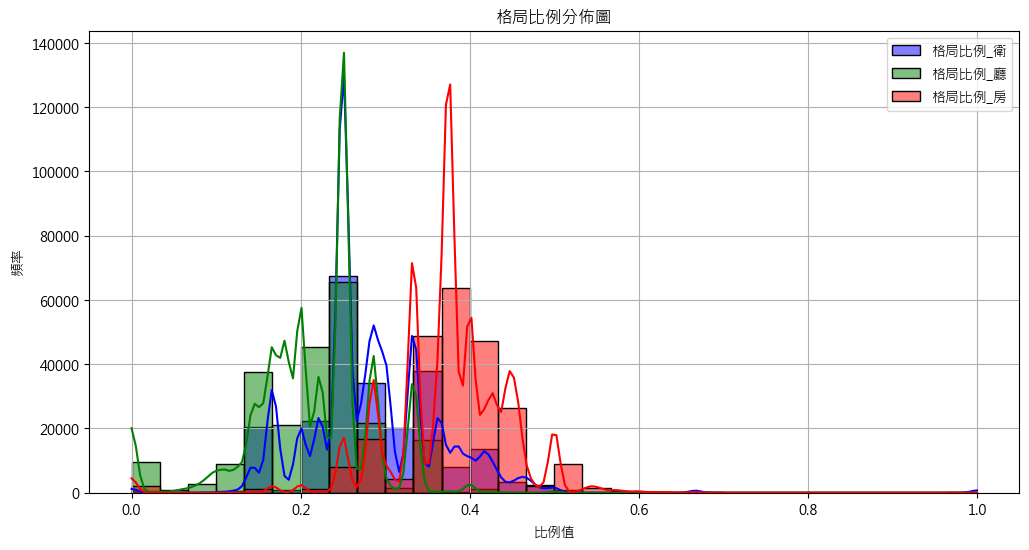

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# 設定圖表大小
plt.figure(figsize=(12, 6))

# 使用 seaborn 畫出三個欄位的分佈圖
sns.histplot(df_filtered['格局比例_衛'], bins=30, kde=True, color='blue', label='格局比例_衛', alpha=0.5)
sns.histplot(df_filtered['格局比例_廳'], bins=30, kde=True, color='green', label='格局比例_廳', alpha=0.5)
sns.histplot(df_filtered['格局比例_房'], bins=30, kde=True, color='red', label='格局比例_房', alpha=0.5)

# 加入圖例與標題
plt.legend()
plt.title('格局比例分佈圖')
plt.xlabel('比例值')
plt.ylabel('頻率')
plt.grid(True)

# 顯示圖表
plt.show()



In [14]:
# 填補數值型特徵的缺失值
numeric_cols_with_na = ['格局比例_衛', '格局比例_廳', '格局比例_房']
for col in numeric_cols_with_na:
    df_filtered[col].fillna(df_filtered[col].median(), inplace=True)


In [15]:
df_filtered.isna().sum()

建物移轉總面積坪    0
格局比例_衛      0
格局比例_廳      0
格局比例_房      0
屋齡          0
有無電梯        0
是否包含車位      0
陽台有無        0
有無管理組織      0
鄉鎮市區        0
建築型態        0
建材種類        0
土地用途        0
建築型態_編碼     0
建材種類_編碼     0
土地用途_編碼     0
dtype: int64

In [16]:
# df_filtered['有無管理組織'].unique
# Label Encoding
df_filtered['有無管理組織'] = df_filtered['有無管理組織'].map({'有': 1, '無': 0})


In [17]:
from sklearn.preprocessing import StandardScaler
# 更新數值型特徵列表
numeric_features = [
    '建物移轉總面積坪', '格局比例_衛', '格局比例_廳', '格局比例_房', '屋齡',
    '建築型態_編碼', '建材種類_編碼', '土地用途_編碼',
    '有無電梯', '是否包含車位', '陽台有無', '有無管理組織'
]


# 初始化標準化器
scaler = StandardScaler()

# 對數值型特徵進行標準化
df_filtered[numeric_features] = scaler.fit_transform(df_filtered[numeric_features])


In [18]:
# 刪除非數值型的類別欄位
df_filtered = df_filtered.drop(['建築型態', '建材種類', '土地用途'], axis=1)


In [19]:
# 檢查資料型態
print(df_filtered.dtypes)

# 檢查是否存在缺失值
print(df_filtered.isnull().sum())


建物移轉總面積坪    float64
格局比例_衛      float64
格局比例_廳      float64
格局比例_房      float64
屋齡          float64
有無電梯        float64
是否包含車位      float64
陽台有無        float64
有無管理組織      float64
鄉鎮市區          int64
建築型態_編碼     float64
建材種類_編碼     float64
土地用途_編碼     float64
dtype: object
建物移轉總面積坪    0
格局比例_衛      0
格局比例_廳      0
格局比例_房      0
屋齡          0
有無電梯        0
是否包含車位      0
陽台有無        0
有無管理組織      0
鄉鎮市區        0
建築型態_編碼     0
建材種類_編碼     0
土地用途_編碼     0
dtype: int64


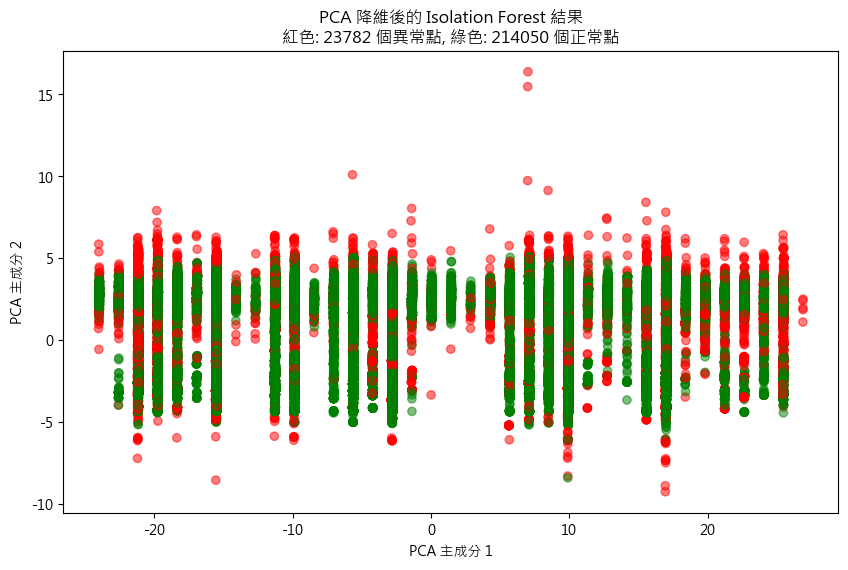

In [28]:
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# 設定 contamination_rate，例如 0.01
contamination_rate = 0.1

# 移除可能已存在的 'outlier' 欄位
if 'outlier' in df_filtered.columns:
    df_filtered = df_filtered.drop('outlier', axis=1)

# 使用 Isolation Forest 偵測異常點
iso_forest = IsolationForest(contamination=contamination_rate, n_estimators=200,random_state=42)
df_filtered['outlier'] = iso_forest.fit_predict(df_filtered)

# 進行 PCA 降維以進行視覺化
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_filtered.drop('outlier', axis=1))

# 將 PCA 結果加入到資料中
df_filtered['PCA1'] = pca_result[:, 0]
df_filtered['PCA2'] = pca_result[:, 1]

# 統計異常值和正常值的數量
num_outliers = np.sum(df_filtered['outlier'] == -1)
num_inliers = np.sum(df_filtered['outlier'] == 1)

# 視覺化結果
plt.figure(figsize=(10, 6))
colors = np.where(df_filtered['outlier'] == -1, 'r', 'g')  # -1為異常點 (紅色), 1為正常點 (綠色)
plt.scatter(df_filtered['PCA1'], df_filtered['PCA2'], c=colors, alpha=0.5)

# 顯示異常值和正常值的數量
plt.title(f'PCA 降維後的 Isolation Forest 結果\n紅色: {num_outliers} 個異常點, 綠色: {num_inliers} 個正常點')
plt.xlabel('PCA 主成分 1')
plt.ylabel('PCA 主成分 2')

plt.show()

In [29]:
print(df_filtered.columns)


Index(['建物移轉總面積坪', '格局比例_衛', '格局比例_廳', '格局比例_房', '屋齡', '有無電梯', '是否包含車位',
       '陽台有無', '有無管理組織', '鄉鎮市區', '建築型態_編碼', '建材種類_編碼', '土地用途_編碼', 'PCA1',
       'PCA2', 'outlier'],
      dtype='object')


In [30]:
# 取得異常值的索引
outlier_indices = df_filtered[df_filtered['outlier'] == -1].index

In [31]:
# 在 df 中刪除對應的異常值資料列
df_cleaned = df.drop(outlier_indices)


In [35]:
df_cleaned.info()
df_cleaned.to_csv('/Volumes/Debbie 1T/BDSE35-1_Final Project_2/data/實價登錄房價_214050row_outlier_isolationForest.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 214050 entries, 0 to 237831
Data columns (total 51 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   鄉鎮市區         214050 non-null  object 
 1   土地位置建物門牌     214050 non-null  object 
 2   交易年月日        214050 non-null  object 
 3   建築完成年月       194465 non-null  float64
 4   建物移轉總面積平方公尺  214050 non-null  float64
 5   有無管理組織       214050 non-null  object 
 6   總價元          214050 non-null  int64  
 7   單價元平方公尺      214050 non-null  float64
 8   備註           59967 non-null   object 
 9   編號           214050 non-null  object 
 10  緯度           214050 non-null  float64
 11  經度           214050 non-null  float64
 12  bad_count    214050 non-null  float64
 13  good_count   214050 non-null  float64
 14  建築型態清整       214050 non-null  object 
 15  陽台有無         214050 non-null  int64  
 16  是否含額外土地      214050 non-null  int64  
 17  建築型態_住商大樓    214050 non-null  int64  
 18  建築型態_公寓      214050 non-null 

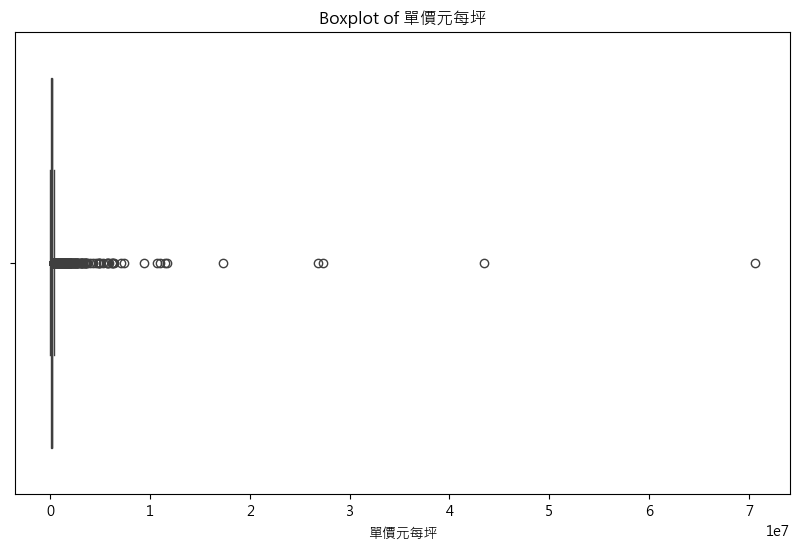

In [33]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['單價元每坪'])
plt.title('Boxplot of 單價元每坪')
plt.show()

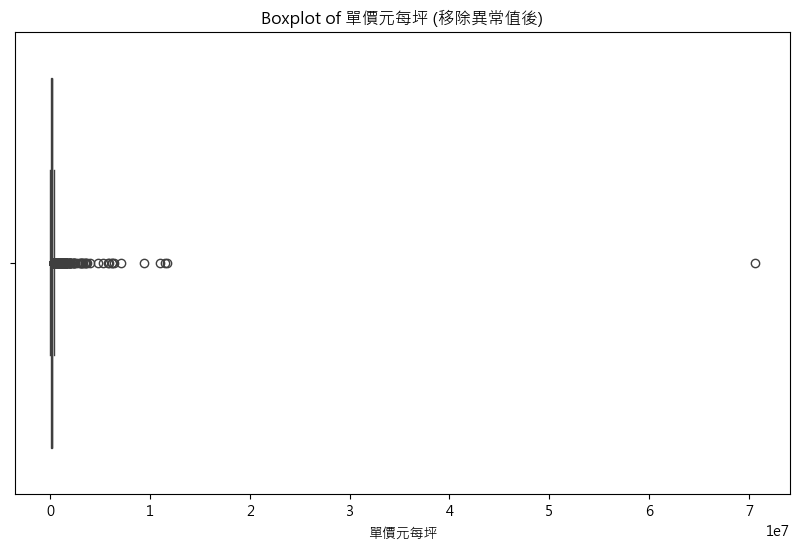

In [34]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_cleaned['單價元每坪'])
plt.title('Boxplot of 單價元每坪 (移除異常值後)')
plt.show()

------

1. 調整 contamination 參數
contamination：這個參數決定了模型預期的異常值比例。

如果您在剔除異常值後，仍有許多極端值，可以考慮增加 contamination 的比例，例如從 0.02 調整到 0.05 或更高，讓更多的資料被標記為異常值。
但要注意，contamination 值過高可能會導致正常資料被誤判為異常。

2. 調整 n_estimators 參數
n_estimators：這個參數決定了 Isolation Forest 中樹的數量。更多的樹通常能夠提高模型的穩定性，但會增加計算時間。

您可以嘗試增加 n_estimators（例如從默認的 100 增加到 200 或 300），以獲得更穩定的異常值偵測結果。


3. 調整 max_samples 參數
max_samples：這個參數決定每棵樹的樣本數量，可以設置為資料集的比例或具體的數量。

如果資料集很大，可以設置 max_samples 為一個較小的比例，例如 0.5 或具體數量，這樣可以加速模型訓練速度。

4. 調整 random_state 參數
random_state：這個參數用於確保模型結果的可重現性。調整這個參數不會改變異常值偵測的比例，但可以用於測試不同的隨機性對結果的影響。

5. 調整 Isolation Forest 參數的建議步驟
逐步調整 contamination：從小比例開始（如 0.02），逐步增加（如 0.05、0.1），觀察剔除異常值後的 Boxplot 變化。

6. 調整 n_estimators：當模型效果不穩定時，可以嘗試增加 n_estimators 的數量。

- 測試不同的 max_samples：特別是當資料量很大時，這個參數可以顯著影響模型的運算時間和效果。

- 視覺化檢查結果：每次調整參數後，繪製 Boxplot 來觀察資料的變化情況。